<a href="https://colab.research.google.com/github/hyehyuni/essa/blob/main/hw_0512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[과제 _ 개념정리]**

**범위 : 파이썬 머신러닝 완벽가이드 ch4. 8 ~ 9 pg.252 ~ 277**


---

## **08. 분류 실습 - 캐글 산탄데르 고객 만족 예측**

캐글의 산탄데르 고객 만족 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측한다. 
* 370개의 피처로 이루어짐 
* 피처 이름은 모두 익명 처리되어 있어 이름만 가지고 어떤 속성인지 추정 불가 
* 클래스 레이블 명은 TARGET, 1이면 불만을 가진 고객, 0이면 만족한 고객임 
* 모델의 성능은 ROC-AUC로 평가 

### **1) 데이터 전처리**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/esaa/자료/santander_customer_satisfaction/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


=> 111개의 피처가 float형, 260개의 피처가 int형으로 모든 피처가 숫자형이며 null 값은 없음 

* Target 속성 값의 분포 

In [2]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


* describe() 메서드를 이용해 각 피처의 값 분포 확인

In [3]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


=> 칼럼을 보면 min의 값이 -999999이다. NaN이나 특정 예외 값을 -99999로 변환했을 것임. pirint로 조사해보면 -999999 값이 116개가 있음을 알 수 있다. 

=>이는 다른 값과 편차가 너무 심하니 가장 빈도가 큰 2로 변환한다.

* var 3 칼럼 수정/ ID 칼럼 삭제

In [4]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

* 클래스 데이터세트/ 피처 데이터세트 분리

In [5]:
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


* 학습 데이터 세트 / 테스트 데이터 세트 분리

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts() / test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


### **2) XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82745
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84055
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88071	validation_1-auc:0.84117
[16]	validation_0-auc:0.88237	validation_1-auc:0.84101
[17]	validation_0-auc:0.88352	validation_1-auc:0.84071
[18]	validation_0-au

=> 테스트 데이터 세트로 예측시 ROC AUC는 약 0.8413임

* 하이퍼 파라미터 튜닝 수행 

  * 칼럼의 개수가 많으므로 과적합 가능성을 가정하고, max_depth, min_child_weigth, colsample_bytree 하이퍼 파라미터만 일차 튜닝 대상으로 한다. 

  * 학습시간이 많이 필요한 ML 모델인 경우 하이퍼 파라미터 튜닝을 수행하는 요령중 첫번째는 먼저 2-3개 정도의 파라미터를 결합해 최적의 파라미터를 찾아낸 뒤, 이를 기반으로 1-2개 파라미터를 결합해 수행하는 것

In [8]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7] , 'min_child_weight':[1,3] , 'colsample_bytree':[0.5, 0.75] }

# cv는 3으로 지정 
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80289	validation_1-auc:0.80420
[1]	validation_0-auc:0.80677	validation_1-auc:0.80892
[2]	validation_0-auc:0.82161	validation_1-auc:0.81979
[3]	validation_0-auc:0.82877	validation_1-auc:0.82509
[4]	validation_0-auc:0.83227	validation_1-auc:0.82868
[5]	validation_0-auc:0.83179	validation_1-auc:0.82649
[6]	validation_0-auc:0.82662	validation_1-auc:0.81879
[7]	validation_0-auc:0.83687	validation_1-auc:0.82901
[8]	validation_0-auc:0.84136	validation_1-auc:0.83545
[9]	validation_0-auc:0.84304	validation_1-auc:0.83301
[10]	validation_0-auc:0.84221	validation_1-auc:0.83210
[11]	validation_0-auc:0.84723	validation_1-auc:0.83457
[12]	validation_0-auc:0.85187	validation_1-auc:0.83740
[13]	validation_0-auc:0.85373	validation_1-auc:0.83434
[14]	validation_0-auc:0.85631	validation_1-auc:0.83641
[15]	validation_0-auc:0.85719	validation_1-auc:0.83617
[16]	validation_0-auc:0.85906	validation_1-auc:0.83443
[17]	validation_0-auc:0.86100	validation_1-auc:0.83417
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80699	validation_1-auc:0.80599
[1]	validation_0-auc:0.81029	validation_1-auc:0.81309
[2]	validation_0-auc:0.82504	validation_1-auc:0.82148
[3]	validation_0-auc:0.83183	validation_1-auc:0.82497
[4]	validation_0-auc:0.83585	validation_1-auc:0.82786
[5]	validation_0-auc:0.83864	validation_1-auc:0.83222
[6]	validation_0-auc:0.83483	validation_1-auc:0.83054
[7]	validation_0-auc:0.84061	validation_1-auc:0.83365
[8]	validation_0-auc:0.84451	validation_1-auc:0.83729
[9]	validation_0-auc:0.84411	validation_1-auc:0.83520
[10]	validation_0-auc:0.84329	validation_1-auc:0.83367
[11]	validation_0-auc:0.84914	validation_1-auc:0.83676
[12]	validation_0-auc:0.85414	validation_1-auc:0.83983
[13]	validation_0-auc:0.85569	validation_1-auc:0.83826
[14]	validation_0-auc:0.85887	validation_1-auc:0.83916
[15]	validation_0-auc:0.85987	validation_1-auc:0.84004
[16]	validation_0-auc:0.86042	validation_1-auc:0.84034
[17]	validation_0-auc:0.86156	validation_1-auc:0.84030
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81203	validation_1-auc:0.80951
[1]	validation_0-auc:0.81450	validation_1-auc:0.81585
[2]	validation_0-auc:0.82678	validation_1-auc:0.82141
[3]	validation_0-auc:0.82958	validation_1-auc:0.82431
[4]	validation_0-auc:0.83590	validation_1-auc:0.82659
[5]	validation_0-auc:0.83743	validation_1-auc:0.82696
[6]	validation_0-auc:0.83508	validation_1-auc:0.82420
[7]	validation_0-auc:0.84130	validation_1-auc:0.82966
[8]	validation_0-auc:0.84500	validation_1-auc:0.83477
[9]	validation_0-auc:0.84551	validation_1-auc:0.83453
[10]	validation_0-auc:0.84494	validation_1-auc:0.83201
[11]	validation_0-auc:0.85031	validation_1-auc:0.83706
[12]	validation_0-auc:0.85489	validation_1-auc:0.83832
[13]	validation_0-auc:0.85636	validation_1-auc:0.83727
[14]	validation_0-auc:0.85873	validation_1-auc:0.83913
[15]	validation_0-auc:0.85979	validation_1-auc:0.83969
[16]	validation_0-auc:0.86059	validation_1-auc:0.83876
[17]	validation_0-auc:0.86171	validation_1-auc:0.83857
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80246	validation_1-auc:0.80463
[1]	validation_0-auc:0.80769	validation_1-auc:0.80995
[2]	validation_0-auc:0.82216	validation_1-auc:0.82059
[3]	validation_0-auc:0.82983	validation_1-auc:0.82797
[4]	validation_0-auc:0.83294	validation_1-auc:0.82964
[5]	validation_0-auc:0.83289	validation_1-auc:0.82807
[6]	validation_0-auc:0.82913	validation_1-auc:0.82282
[7]	validation_0-auc:0.83623	validation_1-auc:0.82949
[8]	validation_0-auc:0.84169	validation_1-auc:0.83424
[9]	validation_0-auc:0.84276	validation_1-auc:0.83206
[10]	validation_0-auc:0.84290	validation_1-auc:0.83209
[11]	validation_0-auc:0.84726	validation_1-auc:0.83490
[12]	validation_0-auc:0.85185	validation_1-auc:0.83765
[13]	validation_0-auc:0.85354	validation_1-auc:0.83497
[14]	validation_0-auc:0.85519	validation_1-auc:0.83661
[15]	validation_0-auc:0.85551	validation_1-auc:0.83619
[16]	validation_0-auc:0.85658	validation_1-auc:0.83520
[17]	validation_0-auc:0.85731	validation_1-auc:0.83493
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80418	validation_1-auc:0.81169
[1]	validation_0-auc:0.81174	validation_1-auc:0.81122
[2]	validation_0-auc:0.82946	validation_1-auc:0.82272
[3]	validation_0-auc:0.83495	validation_1-auc:0.82851
[4]	validation_0-auc:0.83721	validation_1-auc:0.82887
[5]	validation_0-auc:0.83847	validation_1-auc:0.83206
[6]	validation_0-auc:0.83511	validation_1-auc:0.83097
[7]	validation_0-auc:0.84116	validation_1-auc:0.83427
[8]	validation_0-auc:0.84533	validation_1-auc:0.83959
[9]	validation_0-auc:0.84475	validation_1-auc:0.83715
[10]	validation_0-auc:0.84396	validation_1-auc:0.83646
[11]	validation_0-auc:0.84838	validation_1-auc:0.83860
[12]	validation_0-auc:0.85328	validation_1-auc:0.84141
[13]	validation_0-auc:0.85385	validation_1-auc:0.83952
[14]	validation_0-auc:0.85744	validation_1-auc:0.84166
[15]	validation_0-auc:0.85825	validation_1-auc:0.84222
[16]	validation_0-auc:0.85867	validation_1-auc:0.84194
[17]	validation_0-auc:0.85911	validation_1-auc:0.84171
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81098	validation_1-auc:0.80916
[1]	validation_0-auc:0.81358	validation_1-auc:0.81313
[2]	validation_0-auc:0.82606	validation_1-auc:0.82075
[3]	validation_0-auc:0.83126	validation_1-auc:0.82413
[4]	validation_0-auc:0.83431	validation_1-auc:0.82739
[5]	validation_0-auc:0.83669	validation_1-auc:0.82762
[6]	validation_0-auc:0.83388	validation_1-auc:0.82326
[7]	validation_0-auc:0.83882	validation_1-auc:0.82781
[8]	validation_0-auc:0.84310	validation_1-auc:0.83488
[9]	validation_0-auc:0.84383	validation_1-auc:0.83609
[10]	validation_0-auc:0.84300	validation_1-auc:0.83454
[11]	validation_0-auc:0.84807	validation_1-auc:0.83811
[12]	validation_0-auc:0.85239	validation_1-auc:0.84034
[13]	validation_0-auc:0.85437	validation_1-auc:0.83857
[14]	validation_0-auc:0.85624	validation_1-auc:0.83976
[15]	validation_0-auc:0.85747	validation_1-auc:0.83981
[16]	validation_0-auc:0.85828	validation_1-auc:0.83989
[17]	validation_0-auc:0.85956	validation_1-auc:0.83887
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80902	validation_1-auc:0.80594
[1]	validation_0-auc:0.80814	validation_1-auc:0.80463
[2]	validation_0-auc:0.82929	validation_1-auc:0.82254
[3]	validation_0-auc:0.83621	validation_1-auc:0.82625
[4]	validation_0-auc:0.83964	validation_1-auc:0.82813
[5]	validation_0-auc:0.84237	validation_1-auc:0.82614
[6]	validation_0-auc:0.84139	validation_1-auc:0.82316
[7]	validation_0-auc:0.84976	validation_1-auc:0.82936
[8]	validation_0-auc:0.85363	validation_1-auc:0.83274
[9]	validation_0-auc:0.85616	validation_1-auc:0.82987
[10]	validation_0-auc:0.85494	validation_1-auc:0.82878
[11]	validation_0-auc:0.86353	validation_1-auc:0.83263
[12]	validation_0-auc:0.86904	validation_1-auc:0.83413
[13]	validation_0-auc:0.87058	validation_1-auc:0.83155
[14]	validation_0-auc:0.87381	validation_1-auc:0.83338
[15]	validation_0-auc:0.87435	validation_1-auc:0.83100
[16]	validation_0-auc:0.87537	validation_1-auc:0.83110
[17]	validation_0-auc:0.87745	validation_1-auc:0.82964
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80941	validation_1-auc:0.80686
[1]	validation_0-auc:0.81556	validation_1-auc:0.81361
[2]	validation_0-auc:0.83096	validation_1-auc:0.82315
[3]	validation_0-auc:0.83933	validation_1-auc:0.82851
[4]	validation_0-auc:0.84416	validation_1-auc:0.83167
[5]	validation_0-auc:0.84872	validation_1-auc:0.83320
[6]	validation_0-auc:0.84648	validation_1-auc:0.82990
[7]	validation_0-auc:0.85307	validation_1-auc:0.83396
[8]	validation_0-auc:0.85680	validation_1-auc:0.83723
[9]	validation_0-auc:0.85902	validation_1-auc:0.83808
[10]	validation_0-auc:0.85868	validation_1-auc:0.83643
[11]	validation_0-auc:0.86500	validation_1-auc:0.83869
[12]	validation_0-auc:0.87073	validation_1-auc:0.84082
[13]	validation_0-auc:0.87241	validation_1-auc:0.83814
[14]	validation_0-auc:0.87685	validation_1-auc:0.84077
[15]	validation_0-auc:0.87782	validation_1-auc:0.84085
[16]	validation_0-auc:0.87873	validation_1-auc:0.83983
[17]	validation_0-auc:0.87990	validation_1-auc:0.83837
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81702	validation_1-auc:0.81220
[1]	validation_0-auc:0.82046	validation_1-auc:0.81514
[2]	validation_0-auc:0.83453	validation_1-auc:0.82323
[3]	validation_0-auc:0.83849	validation_1-auc:0.82737
[4]	validation_0-auc:0.84346	validation_1-auc:0.82934
[5]	validation_0-auc:0.84713	validation_1-auc:0.83083
[6]	validation_0-auc:0.84430	validation_1-auc:0.82628
[7]	validation_0-auc:0.85255	validation_1-auc:0.83025
[8]	validation_0-auc:0.85662	validation_1-auc:0.83387
[9]	validation_0-auc:0.85863	validation_1-auc:0.83446
[10]	validation_0-auc:0.85883	validation_1-auc:0.83329
[11]	validation_0-auc:0.86666	validation_1-auc:0.83528
[12]	validation_0-auc:0.87216	validation_1-auc:0.83776
[13]	validation_0-auc:0.87498	validation_1-auc:0.83590
[14]	validation_0-auc:0.87717	validation_1-auc:0.83829
[15]	validation_0-auc:0.87780	validation_1-auc:0.83772
[16]	validation_0-auc:0.87851	validation_1-auc:0.83749
[17]	validation_0-auc:0.88025	validation_1-auc:0.83555
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80956	validation_1-auc:0.80714
[1]	validation_0-auc:0.81193	validation_1-auc:0.80854
[2]	validation_0-auc:0.82506	validation_1-auc:0.81970
[3]	validation_0-auc:0.83477	validation_1-auc:0.82709
[4]	validation_0-auc:0.83821	validation_1-auc:0.82847
[5]	validation_0-auc:0.84212	validation_1-auc:0.82840
[6]	validation_0-auc:0.83981	validation_1-auc:0.82187
[7]	validation_0-auc:0.84643	validation_1-auc:0.82964
[8]	validation_0-auc:0.85106	validation_1-auc:0.83246
[9]	validation_0-auc:0.85265	validation_1-auc:0.83022
[10]	validation_0-auc:0.85202	validation_1-auc:0.82886
[11]	validation_0-auc:0.85929	validation_1-auc:0.83305
[12]	validation_0-auc:0.86421	validation_1-auc:0.83632
[13]	validation_0-auc:0.86580	validation_1-auc:0.83527
[14]	validation_0-auc:0.86836	validation_1-auc:0.83751
[15]	validation_0-auc:0.86917	validation_1-auc:0.83644
[16]	validation_0-auc:0.86964	validation_1-auc:0.83589
[17]	validation_0-auc:0.87138	validation_1-auc:0.83500
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80761	validation_1-auc:0.81297
[1]	validation_0-auc:0.81426	validation_1-auc:0.81464
[2]	validation_0-auc:0.83333	validation_1-auc:0.82937
[3]	validation_0-auc:0.83932	validation_1-auc:0.83359
[4]	validation_0-auc:0.84334	validation_1-auc:0.83390
[5]	validation_0-auc:0.84685	validation_1-auc:0.83404
[6]	validation_0-auc:0.84426	validation_1-auc:0.83247
[7]	validation_0-auc:0.84963	validation_1-auc:0.83651
[8]	validation_0-auc:0.85390	validation_1-auc:0.84200
[9]	validation_0-auc:0.85566	validation_1-auc:0.84119
[10]	validation_0-auc:0.85553	validation_1-auc:0.83994
[11]	validation_0-auc:0.86125	validation_1-auc:0.84109
[12]	validation_0-auc:0.86665	validation_1-auc:0.84226
[13]	validation_0-auc:0.86779	validation_1-auc:0.84071
[14]	validation_0-auc:0.87189	validation_1-auc:0.84338
[15]	validation_0-auc:0.87286	validation_1-auc:0.84417
[16]	validation_0-auc:0.87300	validation_1-auc:0.84269
[17]	validation_0-auc:0.87369	validation_1-auc:0.84204
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81604	validation_1-auc:0.81235
[1]	validation_0-auc:0.82253	validation_1-auc:0.81400
[2]	validation_0-auc:0.83498	validation_1-auc:0.82366
[3]	validation_0-auc:0.84183	validation_1-auc:0.82843
[4]	validation_0-auc:0.84412	validation_1-auc:0.82954
[5]	validation_0-auc:0.84630	validation_1-auc:0.82708
[6]	validation_0-auc:0.84502	validation_1-auc:0.82381
[7]	validation_0-auc:0.85257	validation_1-auc:0.82814
[8]	validation_0-auc:0.85582	validation_1-auc:0.83553
[9]	validation_0-auc:0.85747	validation_1-auc:0.83650
[10]	validation_0-auc:0.85660	validation_1-auc:0.83364
[11]	validation_0-auc:0.86296	validation_1-auc:0.83958
[12]	validation_0-auc:0.86754	validation_1-auc:0.84099
[13]	validation_0-auc:0.86875	validation_1-auc:0.83850
[14]	validation_0-auc:0.87078	validation_1-auc:0.84079
[15]	validation_0-auc:0.87244	validation_1-auc:0.84106
[16]	validation_0-auc:0.87329	validation_1-auc:0.83940
[17]	validation_0-auc:0.87409	validation_1-auc:0.83849
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80593	validation_1-auc:0.80898
[1]	validation_0-auc:0.80943	validation_1-auc:0.80802
[2]	validation_0-auc:0.82441	validation_1-auc:0.82007
[3]	validation_0-auc:0.83164	validation_1-auc:0.82390
[4]	validation_0-auc:0.83772	validation_1-auc:0.82921
[5]	validation_0-auc:0.83842	validation_1-auc:0.83047
[6]	validation_0-auc:0.84104	validation_1-auc:0.83226
[7]	validation_0-auc:0.84469	validation_1-auc:0.83537
[8]	validation_0-auc:0.84683	validation_1-auc:0.83548
[9]	validation_0-auc:0.84814	validation_1-auc:0.83619
[10]	validation_0-auc:0.84998	validation_1-auc:0.83683
[11]	validation_0-auc:0.85144	validation_1-auc:0.83648
[12]	validation_0-auc:0.85391	validation_1-auc:0.83602
[13]	validation_0-auc:0.85621	validation_1-auc:0.83614
[14]	validation_0-auc:0.85711	validation_1-auc:0.83651
[15]	validation_0-auc:0.85910	validation_1-auc:0.83675
[16]	validation_0-auc:0.86083	validation_1-auc:0.83563
[17]	validation_0-auc:0.86138	validation_1-auc:0.83521
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80863	validation_1-auc:0.80011
[1]	validation_0-auc:0.80571	validation_1-auc:0.80437
[2]	validation_0-auc:0.82796	validation_1-auc:0.82018
[3]	validation_0-auc:0.83445	validation_1-auc:0.82662
[4]	validation_0-auc:0.83787	validation_1-auc:0.82864
[5]	validation_0-auc:0.84117	validation_1-auc:0.83429
[6]	validation_0-auc:0.84465	validation_1-auc:0.83836
[7]	validation_0-auc:0.84676	validation_1-auc:0.83896
[8]	validation_0-auc:0.84853	validation_1-auc:0.83854
[9]	validation_0-auc:0.85047	validation_1-auc:0.83875
[10]	validation_0-auc:0.85238	validation_1-auc:0.83996
[11]	validation_0-auc:0.85450	validation_1-auc:0.83884
[12]	validation_0-auc:0.85576	validation_1-auc:0.84019
[13]	validation_0-auc:0.85703	validation_1-auc:0.84096
[14]	validation_0-auc:0.85943	validation_1-auc:0.84124
[15]	validation_0-auc:0.86088	validation_1-auc:0.84081
[16]	validation_0-auc:0.86188	validation_1-auc:0.84113
[17]	validation_0-auc:0.86250	validation_1-auc:0.84169
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82051	validation_1-auc:0.81706
[1]	validation_0-auc:0.81489	validation_1-auc:0.81463
[2]	validation_0-auc:0.82613	validation_1-auc:0.82392
[3]	validation_0-auc:0.83159	validation_1-auc:0.82687
[4]	validation_0-auc:0.83529	validation_1-auc:0.82743
[5]	validation_0-auc:0.84072	validation_1-auc:0.83137
[6]	validation_0-auc:0.84302	validation_1-auc:0.83442
[7]	validation_0-auc:0.84511	validation_1-auc:0.83555
[8]	validation_0-auc:0.84587	validation_1-auc:0.83638
[9]	validation_0-auc:0.84812	validation_1-auc:0.83673
[10]	validation_0-auc:0.85143	validation_1-auc:0.83526
[11]	validation_0-auc:0.85397	validation_1-auc:0.83620
[12]	validation_0-auc:0.85616	validation_1-auc:0.83763
[13]	validation_0-auc:0.85783	validation_1-auc:0.83704
[14]	validation_0-auc:0.85973	validation_1-auc:0.83846
[15]	validation_0-auc:0.86155	validation_1-auc:0.83830
[16]	validation_0-auc:0.86278	validation_1-auc:0.83844
[17]	validation_0-auc:0.86419	validation_1-auc:0.83895
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80803	validation_1-auc:0.80806
[1]	validation_0-auc:0.80888	validation_1-auc:0.80894
[2]	validation_0-auc:0.82405	validation_1-auc:0.81945
[3]	validation_0-auc:0.83156	validation_1-auc:0.82609
[4]	validation_0-auc:0.83401	validation_1-auc:0.82772
[5]	validation_0-auc:0.83658	validation_1-auc:0.82950
[6]	validation_0-auc:0.84047	validation_1-auc:0.83059
[7]	validation_0-auc:0.84358	validation_1-auc:0.83185
[8]	validation_0-auc:0.84541	validation_1-auc:0.83323
[9]	validation_0-auc:0.84653	validation_1-auc:0.83440
[10]	validation_0-auc:0.84920	validation_1-auc:0.83548
[11]	validation_0-auc:0.85030	validation_1-auc:0.83627
[12]	validation_0-auc:0.85268	validation_1-auc:0.83664
[13]	validation_0-auc:0.85483	validation_1-auc:0.83676
[14]	validation_0-auc:0.85628	validation_1-auc:0.83643
[15]	validation_0-auc:0.85783	validation_1-auc:0.83561
[16]	validation_0-auc:0.85833	validation_1-auc:0.83599
[17]	validation_0-auc:0.85876	validation_1-auc:0.83658
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80906	validation_1-auc:0.80435
[1]	validation_0-auc:0.80610	validation_1-auc:0.80703
[2]	validation_0-auc:0.82829	validation_1-auc:0.82098
[3]	validation_0-auc:0.83657	validation_1-auc:0.82669
[4]	validation_0-auc:0.83911	validation_1-auc:0.82849
[5]	validation_0-auc:0.84163	validation_1-auc:0.83122
[6]	validation_0-auc:0.84566	validation_1-auc:0.83619
[7]	validation_0-auc:0.84720	validation_1-auc:0.83653
[8]	validation_0-auc:0.84844	validation_1-auc:0.83526
[9]	validation_0-auc:0.84960	validation_1-auc:0.83672
[10]	validation_0-auc:0.85155	validation_1-auc:0.83775
[11]	validation_0-auc:0.85323	validation_1-auc:0.83779
[12]	validation_0-auc:0.85457	validation_1-auc:0.83858
[13]	validation_0-auc:0.85554	validation_1-auc:0.83864
[14]	validation_0-auc:0.85653	validation_1-auc:0.83865
[15]	validation_0-auc:0.85860	validation_1-auc:0.83784
[16]	validation_0-auc:0.85972	validation_1-auc:0.83823
[17]	validation_0-auc:0.86067	validation_1-auc:0.83797
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81882	validation_1-auc:0.81739
[1]	validation_0-auc:0.81386	validation_1-auc:0.81337
[2]	validation_0-auc:0.82661	validation_1-auc:0.82334
[3]	validation_0-auc:0.83557	validation_1-auc:0.82907
[4]	validation_0-auc:0.83892	validation_1-auc:0.83167
[5]	validation_0-auc:0.84144	validation_1-auc:0.83105
[6]	validation_0-auc:0.84403	validation_1-auc:0.83360
[7]	validation_0-auc:0.84648	validation_1-auc:0.83417
[8]	validation_0-auc:0.84841	validation_1-auc:0.83581
[9]	validation_0-auc:0.84876	validation_1-auc:0.83592
[10]	validation_0-auc:0.85065	validation_1-auc:0.83624
[11]	validation_0-auc:0.85204	validation_1-auc:0.83676
[12]	validation_0-auc:0.85449	validation_1-auc:0.83495
[13]	validation_0-auc:0.85519	validation_1-auc:0.83583
[14]	validation_0-auc:0.85682	validation_1-auc:0.83720
[15]	validation_0-auc:0.85847	validation_1-auc:0.83743
[16]	validation_0-auc:0.85930	validation_1-auc:0.83756
[17]	validation_0-auc:0.86089	validation_1-auc:0.83841
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81573	validation_1-auc:0.81067
[1]	validation_0-auc:0.81402	validation_1-auc:0.80774
[2]	validation_0-auc:0.82912	validation_1-auc:0.81864
[3]	validation_0-auc:0.83834	validation_1-auc:0.82490
[4]	validation_0-auc:0.84340	validation_1-auc:0.82924
[5]	validation_0-auc:0.84800	validation_1-auc:0.83252
[6]	validation_0-auc:0.85152	validation_1-auc:0.83472
[7]	validation_0-auc:0.85737	validation_1-auc:0.83466
[8]	validation_0-auc:0.86002	validation_1-auc:0.83343
[9]	validation_0-auc:0.86333	validation_1-auc:0.83595
[10]	validation_0-auc:0.86764	validation_1-auc:0.83618
[11]	validation_0-auc:0.87055	validation_1-auc:0.83591
[12]	validation_0-auc:0.87303	validation_1-auc:0.83511
[13]	validation_0-auc:0.87531	validation_1-auc:0.83573
[14]	validation_0-auc:0.87644	validation_1-auc:0.83532
[15]	validation_0-auc:0.87864	validation_1-auc:0.83346
[16]	validation_0-auc:0.87995	validation_1-auc:0.83380
[17]	validation_0-auc:0.88099	validation_1-auc:0.83336
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81428	validation_1-auc:0.80541
[1]	validation_0-auc:0.81563	validation_1-auc:0.81177
[2]	validation_0-auc:0.83592	validation_1-auc:0.82066
[3]	validation_0-auc:0.84379	validation_1-auc:0.82740
[4]	validation_0-auc:0.85017	validation_1-auc:0.83233
[5]	validation_0-auc:0.85384	validation_1-auc:0.83517
[6]	validation_0-auc:0.85918	validation_1-auc:0.83931
[7]	validation_0-auc:0.86245	validation_1-auc:0.83779
[8]	validation_0-auc:0.86419	validation_1-auc:0.83818
[9]	validation_0-auc:0.86613	validation_1-auc:0.83712
[10]	validation_0-auc:0.86933	validation_1-auc:0.83600
[11]	validation_0-auc:0.87184	validation_1-auc:0.83711
[12]	validation_0-auc:0.87415	validation_1-auc:0.83710
[13]	validation_0-auc:0.87716	validation_1-auc:0.83639
[14]	validation_0-auc:0.87865	validation_1-auc:0.83795
[15]	validation_0-auc:0.88110	validation_1-auc:0.83841
[16]	validation_0-auc:0.88358	validation_1-auc:0.83779
[17]	validation_0-auc:0.88461	validation_1-auc:0.83794
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82448	validation_1-auc:0.81823
[1]	validation_0-auc:0.82212	validation_1-auc:0.81592
[2]	validation_0-auc:0.83464	validation_1-auc:0.82639
[3]	validation_0-auc:0.84121	validation_1-auc:0.82994
[4]	validation_0-auc:0.84804	validation_1-auc:0.83439
[5]	validation_0-auc:0.85362	validation_1-auc:0.83314
[6]	validation_0-auc:0.85620	validation_1-auc:0.83629
[7]	validation_0-auc:0.86025	validation_1-auc:0.83581
[8]	validation_0-auc:0.86252	validation_1-auc:0.83743
[9]	validation_0-auc:0.86649	validation_1-auc:0.83646
[10]	validation_0-auc:0.87101	validation_1-auc:0.83606
[11]	validation_0-auc:0.87345	validation_1-auc:0.83743
[12]	validation_0-auc:0.87701	validation_1-auc:0.83809
[13]	validation_0-auc:0.88044	validation_1-auc:0.83779
[14]	validation_0-auc:0.88136	validation_1-auc:0.83869
[15]	validation_0-auc:0.88292	validation_1-auc:0.83977
[16]	validation_0-auc:0.88460	validation_1-auc:0.83955
[17]	validation_0-auc:0.88560	validation_1-auc:0.83952
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81642	validation_1-auc:0.81216
[1]	validation_0-auc:0.81467	validation_1-auc:0.81133
[2]	validation_0-auc:0.82902	validation_1-auc:0.82239
[3]	validation_0-auc:0.83775	validation_1-auc:0.82795
[4]	validation_0-auc:0.84354	validation_1-auc:0.83096
[5]	validation_0-auc:0.84790	validation_1-auc:0.83441
[6]	validation_0-auc:0.85080	validation_1-auc:0.83508
[7]	validation_0-auc:0.85454	validation_1-auc:0.83765
[8]	validation_0-auc:0.85680	validation_1-auc:0.83712
[9]	validation_0-auc:0.85991	validation_1-auc:0.83639
[10]	validation_0-auc:0.86257	validation_1-auc:0.83788
[11]	validation_0-auc:0.86486	validation_1-auc:0.83696
[12]	validation_0-auc:0.86742	validation_1-auc:0.83751
[13]	validation_0-auc:0.86908	validation_1-auc:0.83692
[14]	validation_0-auc:0.87015	validation_1-auc:0.83647
[15]	validation_0-auc:0.87203	validation_1-auc:0.83610
[16]	validation_0-auc:0.87312	validation_1-auc:0.83591
[17]	validation_0-auc:0.87401	validation_1-auc:0.83522
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81195	validation_1-auc:0.80615
[1]	validation_0-auc:0.81510	validation_1-auc:0.81289
[2]	validation_0-auc:0.83475	validation_1-auc:0.82645
[3]	validation_0-auc:0.84423	validation_1-auc:0.83140
[4]	validation_0-auc:0.84952	validation_1-auc:0.83408
[5]	validation_0-auc:0.85317	validation_1-auc:0.83493
[6]	validation_0-auc:0.85713	validation_1-auc:0.83850
[7]	validation_0-auc:0.85924	validation_1-auc:0.83793
[8]	validation_0-auc:0.86016	validation_1-auc:0.83809
[9]	validation_0-auc:0.86307	validation_1-auc:0.83816
[10]	validation_0-auc:0.86572	validation_1-auc:0.83931
[11]	validation_0-auc:0.86748	validation_1-auc:0.83981
[12]	validation_0-auc:0.87020	validation_1-auc:0.83906
[13]	validation_0-auc:0.87270	validation_1-auc:0.84018
[14]	validation_0-auc:0.87371	validation_1-auc:0.84127
[15]	validation_0-auc:0.87558	validation_1-auc:0.84117
[16]	validation_0-auc:0.87630	validation_1-auc:0.84078
[17]	validation_0-auc:0.87673	validation_1-auc:0.84143
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82218	validation_1-auc:0.81819
[1]	validation_0-auc:0.82120	validation_1-auc:0.81682
[2]	validation_0-auc:0.83459	validation_1-auc:0.82497
[3]	validation_0-auc:0.84312	validation_1-auc:0.82940
[4]	validation_0-auc:0.84793	validation_1-auc:0.83178
[5]	validation_0-auc:0.85339	validation_1-auc:0.83203
[6]	validation_0-auc:0.85638	validation_1-auc:0.83512
[7]	validation_0-auc:0.86082	validation_1-auc:0.83538
[8]	validation_0-auc:0.86250	validation_1-auc:0.83772
[9]	validation_0-auc:0.86569	validation_1-auc:0.83589
[10]	validation_0-auc:0.86855	validation_1-auc:0.83342
[11]	validation_0-auc:0.87103	validation_1-auc:0.83398
[12]	validation_0-auc:0.87268	validation_1-auc:0.83472
[13]	validation_0-auc:0.87475	validation_1-auc:0.83576
[14]	validation_0-auc:0.87519	validation_1-auc:0.83642
[15]	validation_0-auc:0.87568	validation_1-auc:0.83708
[16]	validation_0-auc:0.87705	validation_1-auc:0.83742
[17]	validation_0-auc:0.87816	validation_1-auc:0.83725
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81270	validation_1-auc:0.81076
[1]	validation_0-auc:0.81820	validation_1-auc:0.81360
[2]	validation_0-auc:0.83353	validation_1-auc:0.83010
[3]	validation_0-auc:0.83823	validation_1-auc:0.83429
[4]	validation_0-auc:0.84125	validation_1-auc:0.83363
[5]	validation_0-auc:0.83979	validation_1-auc:0.83299
[6]	validation_0-auc:0.83796	validation_1-auc:0.83148
[7]	validation_0-auc:0.84384	validation_1-auc:0.83526
[8]	validation_0-auc:0.84676	validation_1-auc:0.83677
[9]	validation_0-auc:0.84731	validation_1-auc:0.83538
[10]	validation_0-auc:0.84726	validation_1-auc:0.83485
[11]	validation_0-auc:0.85253	validation_1-auc:0.84007
[12]	validation_0-auc:0.85678	validation_1-auc:0.84255
[13]	validation_0-auc:0.85821	validation_1-auc:0.84121
[14]	validation_0-auc:0.86100	validation_1-auc:0.84394
[15]	validation_0-auc:0.86250	validation_1-auc:0.84436
[16]	validation_0-auc:0.86371	validation_1-auc:0.84416
[17]	validation_0-auc:0.86531	validation_1-auc:0.84329
[18]	validation_0-au

=> 이전 예제의 ROC-AUC가 약 0.8413에서 'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_weight': 3에서 0.8451로 약간 개선됨 

*교재와 다른 결과가 나왔지만, 교재의 코드 그대로 수행함*

In [10]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82311	validation_1-auc:0.81793
[1]	validation_0-auc:0.82585	validation_1-auc:0.81766
[2]	validation_0-auc:0.82950	validation_1-auc:0.81846
[3]	validation_0-auc:0.83162	validation_1-auc:0.82051
[4]	validation_0-auc:0.83561	validation_1-auc:0.82587
[5]	validation_0-auc:0.83569	validation_1-auc:0.82566
[6]	validation_0-auc:0.83635	validation_1-auc:0.82582
[7]	validation_0-auc:0.83757	validation_1-auc:0.82763
[8]	validation_0-auc:0.83873	validation_1-auc:0.82945
[9]	validation_0-auc:0.83986	validation_1-auc:0.83072
[10]	validation_0-auc:0.84036	validation_1-auc:0.83039
[11]	validation_0-auc:0.84071	validation_1-auc:0.83051
[12]	validation_0-auc:0.84064	validation_1-auc:0.82997
[13]	validation_0-auc:0.84098	validation_1-auc:0.82958
[14]	validation_0-auc:0.84174	validation_1-auc:0.83016
[15]	validation_0-auc:0.84223	validation_1-auc:0.83103
[16]	validation_0-auc:0.84262	validation_1-auc:0.83055
[17]	validation_0-auc:0.84302	validation_1-auc:0.83020
[18]	validation_0-au

=> ROC-AUC의 값이 0.8460으로 이전 테스트보다 살짝 향상된 결과를 보임

* 아쉬운 점 

 * XGBoost가 GBM보다는 빠르지만 아무래도 GBM을 기반으로 하고 있기 때문에 수행 시간이 상당히 더 많이 요구된다. 

 * 앙상블 계열 알고리즘은 과적합이나 잡음에 기본적으로 뛰어난 알고리즘이기에 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격하게 되는 경우는 많지 않다. 

* 피처의 중요도 구하기 

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

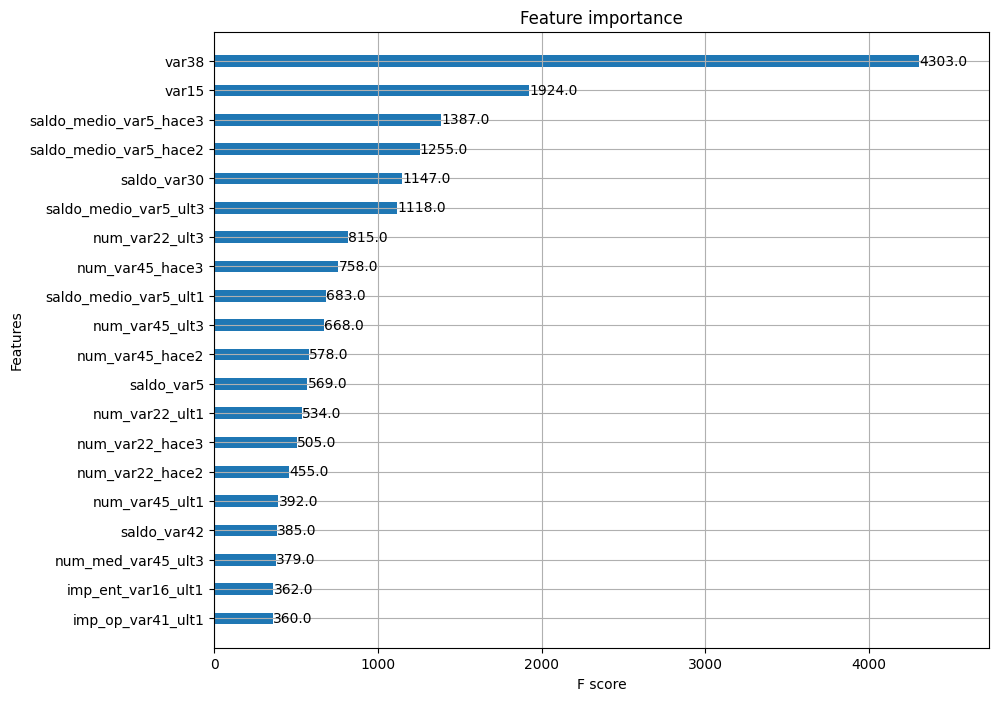

In [12]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax , max_num_features=20, height=0.4)

=> XGBoost에서 var38, var15가 예측 성능 좌우

### **3)LightGBM 모델 학습과 하이퍼 파라미터 튜닝**

앞의 예제 코드에서 만들어진 데이터 세트를 기반으로 LightGBM으로 학습을 수행

In [9]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_logloss: 0.14161
[16]	valid_0's auc: 0.840337	valid_0's binary_loglo

=> LightGBM 수행 결과 ROC AUC가 약 0.8409

=> XGBoost보다 학습에 걸리는 시간이 좀 더 단축됨

* 하이퍼 파라미터에 대한 튜닝

In [13]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32,64],
          'max_depth':[128,160],
          'min_child_samples':[60,100],
          'subsample':[0.8,1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train),(X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.824305	training's binary_logloss: 0.156217	valid_1's auc: 0.819488	valid_1's binary_logloss: 0.165016
[2]	training's auc: 0.828798	training's binary_logloss: 0.150959	valid_1's auc: 0.822075	valid_1's binary_logloss: 0.159734
[3]	training's auc: 0.839609	training's binary_logloss: 0.147147	valid_1's auc: 0.829436	valid_1's binary_logloss: 0.156119
[4]	training's auc: 0.845158	training's binary_logloss: 0.144107	valid_1's auc: 0.836147	valid_1's binary_logloss: 0.153073
[5]	training's auc: 0.847711	training's binary_logloss: 0.14162	valid_1's auc: 0.839041	valid_1's binary_logloss: 0.150773
[6]	training's auc: 0.849184	training's binary_logloss: 0.139622	valid_1's auc: 0.839076	valid_1's binary_logloss: 0.148948
[7]	training's auc: 0.85094	training's binary_logloss: 0.13786	valid_1's auc: 0.839943	valid_1's binary_logloss: 0.147346
[8]	training's auc: 0.853386	training's binary_logloss: 0.136418	valid_1's auc: 0.84098	valid_1's binary_logloss: 0.146068
[9]	training

* 위의 하이퍼 파라미터를 LightGBM

In [14]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sumbsample
[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.141254
[16]	

## **09. 분류 실습 - 캐글 신용카드 사기 검출**

* 해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있다. 

* class는 0과 1로 분류되는데, 0이 사기가 아닌 정상저긴 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션을 의미함

* 전체 데이터의 약 0.172%값만이 레이블 값이 1임



### **1) 언더 샘플링과 오버 샘플링의 이해**

레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때, 예측 성능의 문제가 발생할 수 있다. 

=> 이는 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적기 때문에 발생한다. 

=> 이를 해결하는 방법이 오버 샘플링과 언더 샘플링이다. (주로 오버 샘플링 방식이 예측 성능상 더 유리한 경우가 많음)

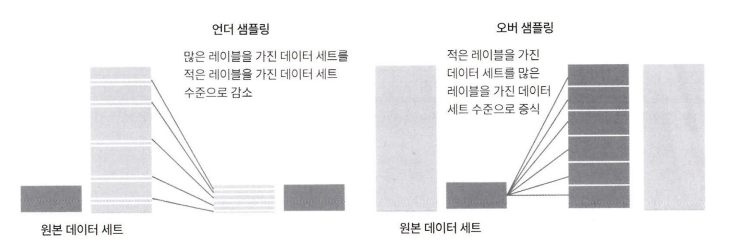

(1) 언더 샘플링 

많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식

즉, 정상 레이블을 가진 데이터가 10000건, 이상 레이블을 가진 데이터가 100건 있으면, 정상 레이블 데이터를 100건으로 줄여버리는 방식
* 장점 : 이렇게 정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여버린 상태에서 학습을 수행하면 과도하게 정상 레이블로 학습/예측하는 부작용 개선 가능 
* 단점:  제대로된 학습을 수행할 수 없다는 단점 존재


(2) 오버 샘플링 

이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법 

동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 의미가 없으므로 원본 데이터의 피처값들을 아주 약간만 변경하여 증식

* 대표적으로 SMOTE 방법 
 * 이는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터를 생성
 * imbalanced-learn 패키지 사용

### **2) 데이터 일차 가공 및 모델 학습/예측/평가**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/esaa/자료/creditcard/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


=> V로 시작하는 피처들의 의미는 알 수가 없음 

=> time 피처의 경우는 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없기에 제거, Amount 피처는 신용카드 트랙잭션 금액을 의미 

=> class 는 레이블로서 0의 경우 정상, 1의 경우 사기 트랜잭션임 

In [16]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

* get_preprocessed_df() 함수 만들기 : 인자로 입력된 데이터 프레임을 복사하고 이를 가공하여 반환

In [18]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

* get_train_test_dataset() : get_preprocessed_df 함수를 호출한 뒤, 학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트를 반환

In [19]:
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

* 레이블 값 비율을 백분율로 환산하여 잘 분할되었는지 확인

In [20]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


=> 큰 차이가 없이 잘 분할됨 

* 예측 성능 평가 함수 get_clf_eval() : 3장에서 학습

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

* 로지스틱 회귀 분석 방법 사용

In [22]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   60    88]]
정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946,    F1: 0.7097, AUC:0.9593


=> 정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946,    F1: 0.7097, AUC:0.9593임을 확인

* get_model_train_eval() 함수 생성 

 * 앞으로 수행할 예제 코드에서 반복적으로 모델을 변경해 학습/예측./평가할 것이므로 이를 위한 별도의 함수를 생성 

 * 인자로 사이킷런의 estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가를 수행하는 역할을 함 

In [23]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

* LightGBM 분석 방법 사용

 * 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성시 **boost_from_average=False**로 설정

In [26]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


=> 정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

### **3) 데이터 분포도 변환 후 모델 학습/예측/평가**

왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 ㅌ스트 

* Amount피처의 분포도 확인

<Axes: xlabel='Amount', ylabel='Density'>

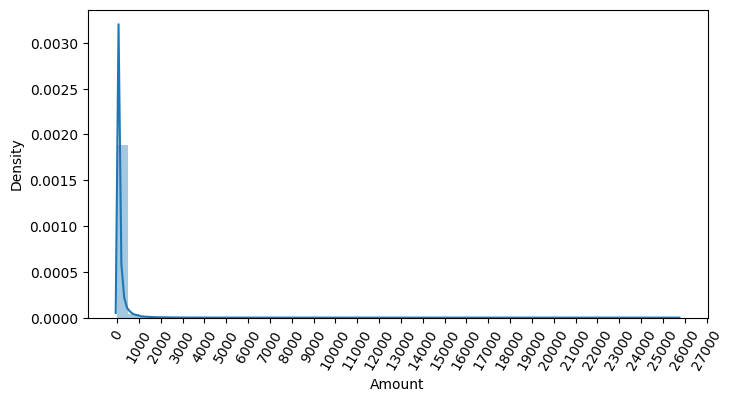

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

=> 카드 사용금액이 1000불 이하인 데이터가 대부분이며 27000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가짐

* get_preprocessed_df() 함수 

In [32]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

* get_train_test_Dataset()  함수

In [33]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


=> 로지스틱 회귀 및 LIghtGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지는 않았음

* 로그변환 수행


  데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법중에 하나

In [34]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [35]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


### **4) 이상치 데이터 제거 후 모델 학습/예측/평가**

이상치 데이터는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터 

- 이상치로 인해 머신러닝 모델의 성능에 영향을 받음 
- IQR 방식 : 사분위 값의 편차를 이용하는 기법 (박스플롯 이용)

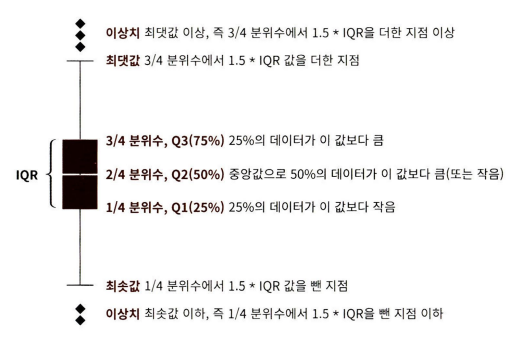

* 이상치 데이터를 IQR을 이용해 제거

 * 많은 피처가 있는 경우 이들 중 결정값과 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋음 
 * 모든 피처들의 이상치를 검출하는 것은 시간이 많이 소모되며, 이상치를 제거하더라도 크게 성능에 기여를 하지 않기 때문임

<Axes: >

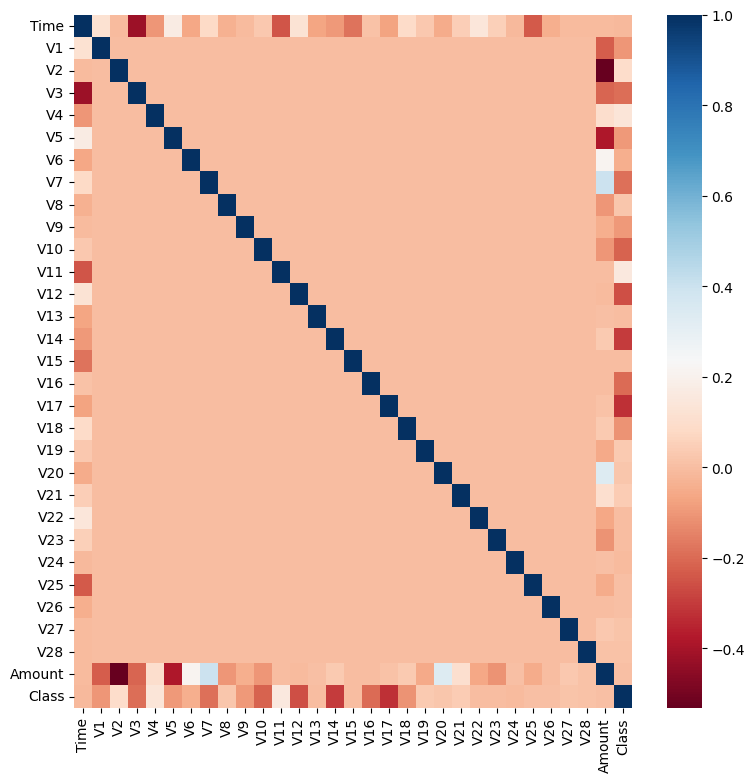

In [36]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')


=> 상관관계 히트맵에서 cmap을 'RdBu'로 설정해 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 진한 빨간색에 가깝게 표현됨 

=> 결정 레이블인 class와 음의 상관관계가 높은것은 V14와 V17



* V14 이상치 제거하기 위한 get_outlier 함수

In [37]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [38]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


=> 8296, 8615, 9035, 9252번 index가 이상치로 추출됨

* 로그 변환후 V14의 이상치를 제거하는 함수

In [39]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, 
                     tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


=> 이상치 데이털르 제거한뒤 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상함

### **5) SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**

* SMOTE 객체의 fit_sample() 메서드

In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


=> SMOTE 적용 전 학습 데이터 세트는 199362건이었지만, SMOTE 적용 후 2배에 가까운 398040건으로 데이터가 증식함

* 로지스틱 회귀 모델

In [41]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


=> 재현율은 크게 증가하지만, 반대로 정밀도가 5.4%로 급격하게 저하됨

* 로지스틱 회귀 모델에 어떤 문제가 발생하고 있는지 시각화를 통해 확인

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

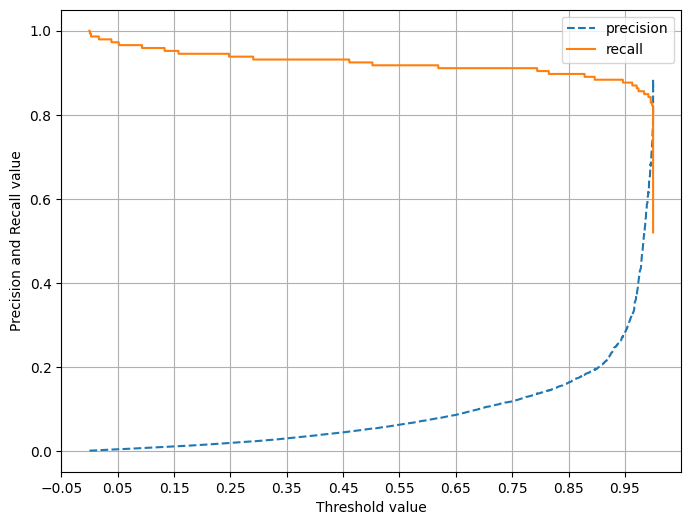

In [43]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

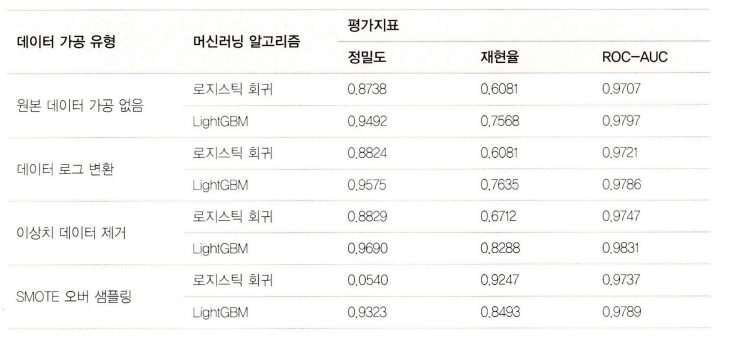